# Training and Visualizing Our Model

## Dependencies

In [ ]:
#Clone Detectron2
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-blg95jt1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-blg95jt1
  Resolved https://github.com/facebookresearch/detectron2.git to commit 654570a2f1e787c6a26c975275360396e2ae833a
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filena

## Imports

In [ ]:
# COMMON LIBRARIES
import os
import cv2
import torch
import pickle
import numpy as np
from glob2 import glob
import tensorflow as tf
from random import randint
# Import pillow modules
from PIL import Image
from PIL import ImageFilter
from datetime import datetime
import torchvision.models as models
from matplotlib import pyplot as plt

# PREPARE DETECTION MODEL
import detectron2

# # VISUALIZATION
 from detectron2.data import MetadataCatalog
 from detectron2.utils.visualizer import Visualizer
 from detectron2.utils.visualizer import ColorMode

# # CONFIGURATION
 from detectron2 import model_zoo
 from detectron2.config import get_cfg

# # EVALUATION
 from detectron2.engine import DefaultPredictor

# PREPARE INPAINTING MODEL

## PConv2D
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.python.keras.utils import conv_utils

## PConv_Unet
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Layer, Input, InputSpec, Lambda, MaxPooling2D ,BatchNormalization, Activation, UpSampling2D, Concatenate, ReLU, LeakyReLU, Conv2D, Flatten, Dense


## Prepare Model Architecture

### Build Pconv-Unet

#### PConv2D

In [ ]:
class PConv2D(Conv2D):
    def __init__(self, *args, **kwargs):
        super(PConv2D, self).__init__(*args, **kwargs)
        self.input_spec = [InputSpec(ndim=4), InputSpec(ndim=4)]


    def build(self, input_shape):
        """Adapted from original _Conv() layer of Keras
        param input_shape: list of dimensions for [img, mask]
        """
        assert self.data_format == 'channels_last', "data format should be `channels_last`"
        #self.input_dim = input_shape[0][-1]
        input_channel = self._get_input_channel(input_shape)
        # Image kernel
        kernel_shape = self.kernel_size + (input_channel, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='img_kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters, ),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None

        # Mask kernel
        self.kernel_mask = K.ones(shape=self.kernel_size +
                                  (input_channel, self.filters))

        # Calculate padding size to achieve zero-padding
        self.pconv_padding = (
            (int((self.kernel_size[0] - 1) / 2),
             int((self.kernel_size[0] - 1) / 2)),
            (int((self.kernel_size[0] - 1) / 2),
             int((self.kernel_size[0] - 1) / 2)),
        )

        # Window size - used for normalization
        self.window_size = self.kernel_size[0] * self.kernel_size[1]

        self.built = True

    def call(self, inputs):
        # Both image and mask must be supplied
        assert isinstance(inputs, list) and len(inputs) == 2

        # Padding done explicitly so that padding becomes part of the masked partial convolution
        images = K.spatial_2d_padding(inputs[0], self.pconv_padding,
                                      self.data_format)
        masks = K.spatial_2d_padding(inputs[1], self.pconv_padding,
                                     self.data_format)

        # Apply convolutions to image
        img_output = K.conv2d((images * masks),
                              self.kernel,
                              strides=self.strides,
                              padding='valid',
                              data_format=self.data_format,
                              dilation_rate=self.dilation_rate)

        # Apply convolutions to mask
        mask_output = K.conv2d(masks,
                               self.kernel_mask,
                               strides=self.strides,
                               padding='valid',
                               data_format=self.data_format,
                               dilation_rate=self.dilation_rate)

        # Calculate the mask ratio on each pixel in the output mask
        mask_ratio = self.window_size / (mask_output + 1e-8)
        # Clip output to be between 0 and 1
        mask_output = K.clip(mask_output, 0, 1)
        # Remove ratio values where there are holes
        mask_ratio = mask_ratio * mask_output
        # Normalize iamge output
        img_output = img_output * mask_ratio

        # Apply bias only to the image (if chosen to do so)
        if self.use_bias:
            img_output = K.bias_add(img_output,
                                    self.bias,
                                    data_format=self.data_format)

        # Apply activations on the image
        if self.activation is not None:
            img_output = self.activation(img_output)

        return [img_output, mask_output]

    def compute_output_shape(self, input_shape):
        space = input_shape[0][1:-1]
        new_space = []
        for i in range(len(space)):
            new_dim = conv_utils.conv_output_length(
                space[i],
                self.kernel_size[i],
                padding='same',
                stride=self.strides[i],
                dilation=self.dilation_rate[i])
            new_space.append(new_dim)
        new_shape = (input_shape[0][0], ) + tuple(new_space) + (self.filters, )
        return [new_shape, new_shape]

    def _get_input_channel(self, input_shape):
        channel_axis = -1
        if input_shape[0].dims[channel_axis].value is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        return int(input_shape[0][-1])

#### Build Pconv-Unet

In [ ]:
def build_pconv_unet(img_shape, fine_tuning=False, train_bn=True):
    # INPUTS
    inputs_img = Input((img_shape, img_shape, 3), name='inputs_img')
    inputs_mask = Input((img_shape, img_shape, 3), name='inputs_mask')
    invers_mask =  1 - inputs_mask

    # Concatenate the image and mask
    input_layer = Concatenate()([inputs_img, invers_mask])

    # Encoding path
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(input_layer)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3,activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool5)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)


    # P_ENCODER
    def encoder_block(img_in,
                      mask_in,
                      filters,
                      kernel_size,
                      batch_norm=True,
                      freeze_bn=False,
                      count=''):
        if count != '':
            count = '_' + count

        pconv, mask = PConv2D(filters,
                              kernel_size,
                              strides=2,
                              padding='same',
                              name='pconv2d_enc' + count)([img_in, mask_in])
        if batch_norm:
            pconv = BatchNormalization(name='bn_enc' + count)(
                pconv, training=not freeze_bn)
        pconv = Activation('relu')(pconv)

        return pconv, mask

    e_conv1, e_mask1 = encoder_block(inputs_img,
                                     inputs_mask,
                                     64,
                                     7,
                                     batch_norm=False,
                                     count='1')
    e_conv2, e_mask2 = encoder_block(e_conv1,
                                     e_mask1,
                                     128,
                                     5,
                                     freeze_bn=fine_tuning,
                                     count='2')
    e_conv3, e_mask3 = encoder_block(e_conv2,
                                     e_mask2,
                                     256,
                                     5,
                                     freeze_bn=fine_tuning,
                                     count='3')
    e_conv4, e_mask4 = encoder_block(e_conv3,
                                     e_mask3,
                                     512,
                                     3,
                                     freeze_bn=fine_tuning,
                                     count='4')
    e_conv5, e_mask5 = encoder_block(e_conv4,
                                     e_conv4,
                                     512,
                                     3,
                                     freeze_bn=fine_tuning,
                                     count='5')

    e_conv6, e_mask6 = encoder_block(e_conv5,
                                     e_mask5,
                                     512,
                                     3,
                                     freeze_bn=fine_tuning,
                                     count='6')

    concatenated = Concatenate(axis=3)([e_conv6, pool6])

    conv7 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(concatenated)

        # define atrous convolutional block with four dilation rates
    d1 = Conv2D(64, 3, activation='relu', padding='same', dilation_rate=2)(conv7)
    d2 = Conv2D(128, 3, activation='relu', padding='same', dilation_rate=4)(d1)
    d3 = Conv2D(256, 3, activation='relu', padding='same', dilation_rate=8)(d2)
    d4 = Conv2D(512, 3, activation='relu', padding='same', dilation_rate=16)(d3)

    #define the output
    atrous_output = tf.reshape(d4, (-1, 4, 4, 512))

    # DECODER
    def decoder_block(img_in,
                      mask_in,
                      e_conv,
                      e_mask,
                      filters,
                      kernel_size,
                      batch_norm=True,
                      count=''):
        if count != '':
            count = '_' + count

        up_img = UpSampling2D(size=(2, 2),
                              name='img_upsamp_dec' + count)(img_in)
        up_mask = UpSampling2D(size=(2, 2),
                               name='mask_upsamp_dec' + count)(mask_in)
        concat_img = Concatenate(axis=3, name='img_concat_dec' +
                                 count)([e_conv, up_img])
        concat_mask = Concatenate(axis=3, name='mask_concat_dec' +
                                  count)([e_mask, up_mask])
        pconv, mask = PConv2D(filters,
                              kernel_size,
                              padding='same',
                              name='pconv2d_dec' +
                              count)([concat_img, concat_mask])

        if batch_norm:
            pconv = BatchNormalization(name='bn_dec' + count)(pconv)
        pconv = LeakyReLU(alpha=0.2, name='leaky_dec' + count)(pconv)
        return pconv, mask

    # DECODER

    d_conv11, d_mask11 = decoder_block(atrous_output,#conv7,
                                       e_mask6,
                                       e_conv5,
                                       e_mask5,
                                       512,
                                       3,
                                       count='7')

    d_conv12, d_mask12 = decoder_block(d_conv11,
                                       d_mask11,
                                       e_conv4,
                                       e_mask4,
                                       512,
                                       3,
                                       count='8')
    d_conv13, d_mask13 = decoder_block(d_conv12,
                                       d_mask12,
                                       e_conv3,
                                       e_mask3,
                                       256,
                                       3,
                                       count='9')
    d_conv14, d_mask14 = decoder_block(d_conv13,
                                       d_mask13,
                                       e_conv2,
                                       e_mask2,
                                       128,
                                       3,
                                       count='10')
    d_conv15, d_mask15 = decoder_block(d_conv14,
                                       d_mask14,
                                       e_conv1,
                                       e_mask1,
                                       64,
                                       3,
                                       count='11')
    d_conv16, d_mask16 = decoder_block(d_conv15,
                                       d_mask15,
                                       inputs_img,
                                       inputs_mask,
                                       3,
                                       3,
                                       batch_norm=False,
                                       count='12')
    outputs = Conv2D(3, 1, activation='sigmoid', name='outputs_img')(d_conv16)

    # Setup the model inputs / outputs
    model = Model(inputs=[inputs_img, inputs_mask], outputs=outputs)

    # This will also freeze bn parameters `beta` and `gamma`:
    if fine_tuning:
        for l in model.layers:
            if 'bn_enc' in l.name:
                l.trainable = False

    return model

In [ ]:
model = build_pconv_unet(256)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs_mask (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 inputs_img (InputLayer)        [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 256, 3)  0           ['inputs_mask[0][0]']            
                                                                                              

### Discriminator (Local & Global)

#### Local Discriminator

In [ ]:
L_discriminator = keras.Sequential(
    [
        keras.Input(shape=(256, 256, 3)),

        layers.Conv2D(16, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(32, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Flatten(),

        layers.Dense(1024 , activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1024 , activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(1, activation="sigmoid"),
    ],
    name="l_discriminator",
)

L_discriminator.summary()

Model: "l_discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_103 (Conv2D)         (None, 128, 128, 16)      784       
                                                                 
 batch_normalization_18 (Bat  (None, 128, 128, 16)     64        
 chNormalization)                                                
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 128, 128, 16)      0         
                                                                 
 conv2d_104 (Conv2D)         (None, 64, 64, 32)        8224      
                                                                 
 batch_normalization_19 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 64, 64, 32)    

#### Global Discriminator

In [ ]:
g_discriminator = keras.Sequential(
    [
        keras.Input(shape=(256, 256, 3)),

        layers.Conv2D(16, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(32, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),

        layers.Flatten(),

        layers.Dense(1024 , activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1024 , activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(1, activation="sigmoid"),
    ],
    name="g_discriminator",
)
g_discriminator.summary()

Model: "g_discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_97 (Conv2D)          (None, 128, 128, 16)      784       
                                                                 
 batch_normalization_12 (Bat  (None, 128, 128, 16)     64        
 chNormalization)                                                
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 128, 128, 16)      0         
                                                                 
 conv2d_98 (Conv2D)          (None, 64, 64, 32)        8224      
                                                                 
 batch_normalization_13 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 64, 64, 32)    

#### Define Optimizer

In [ ]:
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
LD_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

#LD_optimizer.build([var for var in model.trainable_variables])

bc_loss_fun = tf.keras.losses.BinaryCrossentropy()

### Losses

In [ ]:
def get_vgg16_weights(save_dir):
  pytorch_model = models.vgg16(pretrained=True)

  # select weights in the conv2d layers and transpose them to keras dim ordering:
  wblist_torch = list(pytorch_model.parameters())[:26]
  wblist_keras = []
  for i in range(len(wblist_torch)):
    if wblist_torch[i].dim() == 4:
      w = np.transpose(wblist_torch[i].detach().numpy(), axes=[2, 3, 1, 0])
      wblist_keras.append(w)
    elif wblist_torch[i].dim() == 1:
      b = wblist_torch[i].detach().numpy()
      wblist_keras.append(b)
    else:
      raise Exception('Fully connected layers are not implemented.')

  keras_model = VGG16(include_top=False, weights=None)
  keras_model.set_weights(wblist_keras)
  keras_model.save_weights(save_dir + '/vgg16_pytorch2keras.h5')


def get_vgg16_model(weights):
    """ Creates a vgg model that returns a list of intermediate output values."""
    vgg = tf.keras.applications.VGG16(include_top=False, weights=weights)
    vgg.trainable = False

    outputs = [
        vgg.get_layer(name).output
        for name in ['block1_pool', 'block2_pool', 'block3_pool']
    ]
    return Model(vgg.input, outputs)


class StyleModel(Model):
    """ Build a model that returns the style and content tensors."""
    def __init__(self, weights):  #, style_layers):
        super(StyleModel, self).__init__()
        #self.weights = weights
        self.vgg = get_vgg16_model(weights=weights)
        #self.style_layers = style_layers
        self.vgg.trainable = False
        # Scaling for VGG input
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]

    def call(self, inputs):
        preprocessed_input = tf.identity(inputs)
        Lambda(lambda x: (x - self.mean) / self.std)(preprocessed_input)
        outputs = self.vgg(preprocessed_input)
        return outputs


def loss_l1(y_true, y_pred):
    """
    Size-averaged L1 loss used in all the losses.
    If size_average is True, the l1 losses are means,
    If size_average is False, the l1 losses are sums divided by norm (should be specified),
        only have effect if y_true.ndim = 4.
    """
    if K.ndim(y_true) == 4:
        # images and vgg features
        return K.mean(K.abs(y_pred - y_true), axis=[1, 2, 3])
    elif K.ndim(y_true) == 3:
        # gram matrices
        return K.mean(K.abs(y_pred - y_true), axis=[1, 2])
    else:
        raise NotImplementedError(
            "Calculating L1 loss on 1D tensors? should not occur for this network"
        )


def gram_matrix(x, norm_by_channels=False):
    """Calculate gram matrix used in style loss"""
    # Assertions on input
    assert K.ndim(x) == 4, 'Input tensor should be a 4d (B, H, W, C) tensor'
    assert K.image_data_format(
    ) == 'channels_last', "Please use channels-last format"

    # Permute channels and get resulting shape
    x = K.permute_dimensions(x, (0, 3, 1, 2))
    shape = K.shape(x)
    B, C, H, W = shape[0], shape[1], shape[2], shape[3]

    # Reshape x and do batch dot product
    features = K.reshape(x, K.stack([B, C, H * W]))
    gram = K.batch_dot(features, features, axes=2)

    # Normalize with channels, height and width
    gram = gram / K.cast(C * H * W, x.dtype)
    return gram


def loss_per_pixel(mask, y_true, y_pred):
    """Pixel L1 loss outside the hole / mask"""
    assert K.ndim(y_true) == 4, 'Input tensor should be 4D (B, H, W, C).'
    return K.mean(K.abs(mask * (y_pred - y_true)), axis=[1, 2, 3])


def loss_perceptual(vgg_out, vgg_gt, vgg_comp):
    """Perceptual loss based on VGG16, see. eq. 3 in paper"""
    l = 0
    for o, c, g in zip(vgg_out, vgg_comp, vgg_gt):
        l += loss_l1(o, g) + loss_l1(c, g)
    return l


def loss_style(vgg_out, vgg_gt, vgg_comp):
    """Style loss consisting of two terms: out and comp."""
    style_score = 0.
    for o, g, c in zip(vgg_out, vgg_gt, vgg_comp):
        #print("shapes", o.shape, c.shape, g.shape, "dim", K.ndim(o), K.ndim(c), K.ndim(g))
        gram_gt = gram_matrix(g)
        #print('gram_gt', gram_gt.shape, 'gram_out', gram_matrix(o).shape, gram_matrix(c).shape)
        style_score += loss_l1(gram_matrix(o), gram_gt) + loss_l1(
            gram_matrix(c), gram_gt)
    return style_score


def loss_tv(inv_mask, y_comp):
    """Total variation loss, used for smoothing the hole region, see. eq. 6"""
    assert K.ndim(y_comp) == 4 and K.ndim(
        inv_mask) == 4, 'Input tensors should be 4D (B, H, W, C).'
    ## Create dilated hole region using a 3x3 kernel of all 1s.
    kernel = tf.ones([3, 3, 3, 3], tf.float32)
    dilated_mask = K.conv2d(inv_mask,
                            kernel,
                            data_format='channels_last',
                            padding='same')

    ## Cast values to be [0., 1.], and compute dilated hole region of y_comp
    dilated_mask = K.cast(K.greater(dilated_mask, 0), 'float32')
    P = dilated_mask * y_comp
    ## Calculate total variation loss
    return loss_l1(P[:, 1:, :, :], P[:, :-1, :, :]) + loss_l1(
        P[:, :, 1:, :], P[:, :, :-1, :])

def G_discriminator_loss(g_discriminator, y_pred, targets):
    # Assemble labels that say "all real images"
    input_shape = tf.shape(targets)
    misleading_labels = tf.ones((input_shape[0], 1))

    predictions = g_discriminator(y_pred, training=False)
    d_loss = bc_loss_fun(misleading_labels, predictions)

    # # IMPORTANT: Exclude g_discriminator's trainable weights from gradient calculation and optimization
    # for weight in g_discriminator.trainable_weights:
    #     weight.assign(weight)  # Assign the weights to themselves without any update
    return d_loss

def L_discriminator_loss( y_pred, targets, bounding_box):
    # Assemble labels that say "all real images"
    input_shape = tf.shape(targets)
    misleading_labels = tf.ones((input_shape[0], 1))

    predictions = L_discriminator( bounding_box * y_pred, training=False)
    d_loss = bc_loss_fun(misleading_labels, predictions)

    # # IMPORTANT: Exclude g_discriminator's trainable weights from gradient calculation and optimization
    # for weight in g_discriminator.trainable_weights:
    #     weight.assign(weight)  # Assign the weights to themselves without any update
    return d_loss

def loss_total(model, g_discriminator, batch_size, inputs, targets, vgg16, training=True):
    mask = inputs[1]
    bounding_box = inputs[2]
    y_ = model([inputs[0] , inputs[1]], training=training)

    def loss(g_discriminator, batch_size, y_true, y_pred):


        # The raw output image Iout, but with the non-hole pixels directly set to ground truth
        y_comp = mask * y_true + (1 - mask) * y_pred

        style_pred = vgg16(y_pred)
        style_gt = vgg16(y_true)
        style_comp = vgg16(y_comp)

        # Compute loss components
        G_d_loss = G_discriminator_loss(g_discriminator , y_pred , targets)
        L_d_loss = L_discriminator_loss(y_pred , targets, bounding_box)

        l_valid = loss_per_pixel(mask, y_true, y_pred)
        l_hole = loss_per_pixel((1 - mask), y_true, y_pred)
        l_perc = loss_perceptual(style_pred, style_gt, style_comp)

        l_style = loss_style(style_pred, style_gt, style_comp)
        l_tv = loss_tv((1 - mask), y_comp)

        # Assign weights to the loss terms
        weight_valid = 1.0
        weight_hole = 30.0
        weight_perc = 0.05
        weight_style = 150
        weight_tv = 0.1
        weight_G_d = 0.005  # Weight for g_discriminator loss
        weight_L_d = 0.0008  # Weight for l_discriminator loss

        # Calculate the overall loss
        total_loss = (
            weight_valid * l_valid
            + weight_hole * l_hole
            + weight_perc * l_perc
            + weight_style * l_style
            + weight_tv * l_tv
            + weight_G_d * G_d_loss
            + weight_L_d * L_d_loss

        )


        # Return loss function

        return total_loss
        #return l_valid + 6 * l_hole + 0.05 * l_perc + 120 * l_style + 0.1 * l_tv + G_d_loss


    return loss(g_discriminator, batch_size, targets, y_)

## Training Parameters

Setting Model Parameters

In [ ]:
#Detection
ARCHITECTURE = "mask_rcnn_R_50_FPN_3x"
CONFIG_FILE_PATH = f"COCO-InstanceSegmentation/{ARCHITECTURE}.yaml"
NUM_CLASSES = 19

#Inpainting
IMG_SHAPE  = 256
BATCH_SIZE = 4
EPOCHS = 30
EPOCHS_FT = 30
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Define the VGG16 model for loss calculation
vgg16_weights = '/content/drive/MyDrive/GP5_Ghaida undermask_2022/Implementation on Colab/Image Inpainting Module/Models/vgg16_pytorch2keras.h5'
vgg16 = StyleModel(weights=vgg16_weights)

### Train Steps

In [ ]:
@tf.function
def train_step(model, g_discriminator, example, path, batch_size, optimizer):
    inputs, targets = create_myinput_dataset(example, path, batch_size)
    mask = inputs[1]
    bounding_box = inputs[2]

    y_pred = model( [inputs[0] , inputs[1]], training=True)

    # train the G_discriminator

    # Combine them with real images
    combined_images = tf.concat([y_pred, targets], axis=0)

    # Assemble labels discriminating real from fake images
    input_shape = tf.shape(targets)
    labels = tf.concat(
        [tf.zeros((input_shape[0], 1)), tf.ones((input_shape[0], 1))], axis=0
    )
    # Add random noise to the labels - important trick!
    labels += 0.05 * tf.random.uniform(tf.shape(labels))
    with tf.GradientTape() as tape:
        predictions = g_discriminator(combined_images , training=True)
        d_loss = bc_loss_fun(labels, predictions)
    grads = tape.gradient(d_loss, g_discriminator.trainable_weights)
    d_optimizer.apply_gradients(
        zip(grads, g_discriminator.trainable_weights)
    )

    # train the L_discriminator

    # Combine them with real images
    combined_images = tf.concat([bounding_box * y_pred, bounding_box * targets], axis=0)

    # Assemble labels discriminating real from fake images
    input_shape = tf.shape(targets)
    labels = tf.concat(
        [tf.zeros((input_shape[0], 1)), tf.ones((input_shape[0], 1))], axis=0
    )
    # Add random noise to the labels - important trick!
    labels += 0.05 * tf.random.uniform(tf.shape(labels))
    with tf.GradientTape() as tape:
        predictions = L_discriminator(combined_images , training=True )
        ld_loss = bc_loss_fun(labels, predictions)
    grads = tape.gradient(ld_loss, L_discriminator.trainable_weights)
    LD_optimizer.apply_gradients(
        zip(grads, L_discriminator.trainable_weights)
    )


    # train inpanting model
    with tf.GradientTape() as tape:
        loss = loss_total(model, g_discriminator, batch_size, inputs, targets, vgg16, training=True)

    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))


    return loss

@tf.function
def val_step(model, g_discriminator, example, path, batch_size):
    inputs, targets = create_myinput_dataset(example, path, batch_size)
    loss = loss_total(model, g_discriminator, batch_size, inputs, targets, vgg16, training=False)
    return loss

def fit(model, g_discriminator, input_data, validation_data,epochs, batch_size, steps_per_epoch, validation_steps ,optimizer, save_dir):

    train_loss_results = []
    val_loss_results = []

    Save_count = 0
    Save_On = 1000
    for epoch in range(epochs):


        print("\nStart of epoch %d" % (epoch, ))
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_val_loss_avg = tf.keras.metrics.Mean()

        for step in range(steps_per_epoch):
            example, path = next(input_data)
            loss = train_step(model, g_discriminator, example, path, batch_size, optimizer)

            # Update training metric.
            epoch_loss_avg.update_state(loss)

            average_loss = sum(loss) / len(loss)
            message = f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss:5.20f}, Step:{step} of {steps_per_epoch}"
            sys.stdout.write('\r' + message)
            sys.stdout.flush()

            Save_count = Save_count + 1
            if Save_count > Save_On:
              print("model saved")
              Save_count = 0
              datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

              checkpoint_name = save_dir + '/Deep-vanilla-L&G_D-epoch-' + str(epoch) + '-' + datetime.now().strftime('%Y-%m-%d-%H-%M-%S') + '.h5'
              model.save_weights(checkpoint_name, overwrite=True, save_format='h5')

              g_discriminator_checkpoint_name = save_dir + '/Deep-g_discriminator-epoch-' + str(epoch) + '-' + datetime.now().strftime('%Y-%m-%d-%H-%M-%S') + '.h5'
              g_discriminator.save_weights(g_discriminator_checkpoint_name, overwrite=True, save_format='h5')

              l_discriminator_checkpoint_name = save_dir + '/l_discriminator-epoch-' + str(epoch) + '-' + datetime.now().strftime('%Y-%m-%d-%H-%M-%S') + '.h5'
              L_discriminator.save_weights(l_discriminator_checkpoint_name, overwrite=True, save_format='h5')





        for step_val in range(validation_steps):
                  example_val, path_val = next(validation_data)
                  loss_val = val_step(model, g_discriminator, example_val, path_val, batch_size)
                  epoch_val_loss_avg.update_state(loss_val)
                  # Log every epoch.
                  val_loss_results.append(epoch_val_loss_avg.result())


        print("\n     Training loss: %.4f, Validation loss: %.4f" % (epoch_loss_avg.result(), epoch_val_loss_avg.result()))
        # Log every epoch.
        train_loss_results.append(epoch_loss_avg.result())



        # Reset metrics at the end of each epoch
        epoch_loss_avg.reset_states()

        datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

        checkpoint_name = save_dir + '/Deep-vanilla-L&G_D-epoch-' + str(epoch) + '-' + datetime.now().strftime('%Y-%m-%d-%H-%M-%S') + '.h5'
        model.save_weights(checkpoint_name, overwrite=True, save_format='h5')

        g_discriminator_checkpoint_name = save_dir + '/Deep-g_discriminator-epoch-' + str(epoch) + '-' + datetime.now().strftime('%Y-%m-%d-%H-%M-%S') + '.h5'
        g_discriminator.save_weights(g_discriminator_checkpoint_name, overwrite=True, save_format='h5')

        l_discriminator_checkpoint_name = save_dir + '/l_discriminator-epoch-' + str(epoch) + '-' + datetime.now().strftime('%Y-%m-%d-%H-%M-%S') + '.h5'
        L_discriminator.save_weights(l_discriminator_checkpoint_name, overwrite=True, save_format='h5')

    return {'loss': train_loss_results}


## Prepare Train Data

#### Load

In [ ]:
def load(path):
    as_string = tf.io.read_file(path)
    as_image = tf.image.decode_png(as_string, channels=3)
    resized = tf.image.resize(as_image, (256, 256))
    normalized = tf.divide(resized, 255)
    return normalized, path

def load_boundingBox(path):
    filename = os.path.basename(bytes.decode(path.numpy()))
    dir = os.path.dirname(bytes.decode(path.numpy()))
    folders = os.path.basename(os.path.dirname(dir)) + '/'
    file = folders + filename
    path = "/content/drive/MyDrive/GP5_Ghaida undermask_2022/Dataset/2 Versions (Custom Datasets)/MFDataset/box_masks/"
    as_string = tf.io.read_file(path)
    as_image = tf.image.decode_png(as_string, channels=3)
    resized = tf.image.resize(as_image, (256, 256))
    normalized = tf.divide(resized, 255)
    return normalized

def load_mask(path):
    filename = os.path.basename(bytes.decode(path.numpy()))
    dir = os.path.dirname(bytes.decode(path.numpy()))
    folders = os.path.basename(os.path.dirname(dir)) + '/' + os.path.basename(dir) + '/'
    file = folders + filename
    path = "/content/drive/MyDrive/GP5_Ghaida undermask_2022/Dataset/2 Versions (Custom Datasets)/MFDataset/Segmentations/" + filename
    as_string = tf.io.read_file(path)
    as_image = tf.image.decode_png(as_string, channels=3)
    resized = tf.image.resize(as_image, (256, 256))
    normalized = tf.divide(resized, 255)
    return normalized

def create_myinput_dataset(image_batch, path_batch, batch_size):
    mask_batch = np.stack(
        [load_mask(path_batch[_]) for _ in range(len(path_batch))],
        axis=0)
    box_batch = np.stack(
        [load_mask(path_batch[_]) for _ in range(len(path_batch))],
        axis=0)
    mask_batch = 1 - mask_batch
    # Condition tensor
    bool_mask_batch = tf.convert_to_tensor(mask_batch.copy().astype('bool'), dtype=tf.bool)
    box_batch = tf.convert_to_tensor(box_batch, dtype=tf.float32)
    mask_batch = tf.convert_to_tensor(mask_batch, dtype=tf.float32)
    masked_batch = tf.where(bool_mask_batch, image_batch, 1.0)

    return (masked_batch, mask_batch, box_batch), image_batch

trainfiles = glob('/content/drive/MyDrive/GP5_Ghaida undermask_2022/Dataset/2 Versions (Custom Datasets)/MFDataset/Orig_imgs/train/**/*.png')
trainds = tf.data.Dataset.from_tensor_slices(trainfiles).map(load)
trainds = trainds.batch(BATCH_SIZE).repeat().shuffle(buffer_size=100)
trainds = trainds.prefetch(buffer_size=AUTOTUNE)

valfiles = glob('/content/drive/MyDrive/GP5_Ghaida undermask_2022/Dataset/2 Versions (Custom Datasets)/MFDataset/Orig_imgs/validation/**/*.png')
valds = tf.data.Dataset.from_tensor_slices(valfiles).map(load)
valds = valds.batch(BATCH_SIZE).repeat().shuffle(buffer_size=100)
valds = valds.prefetch(buffer_size=AUTOTUNE)

#### Visualize Training images (1 Batch)

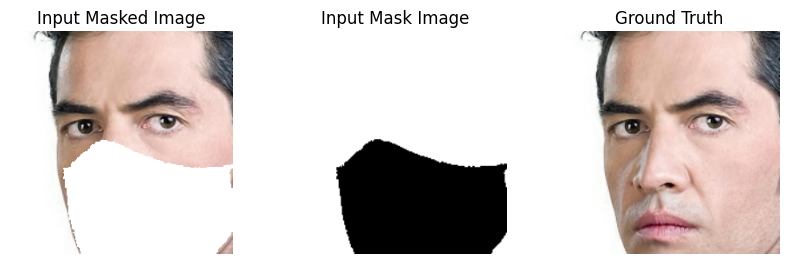

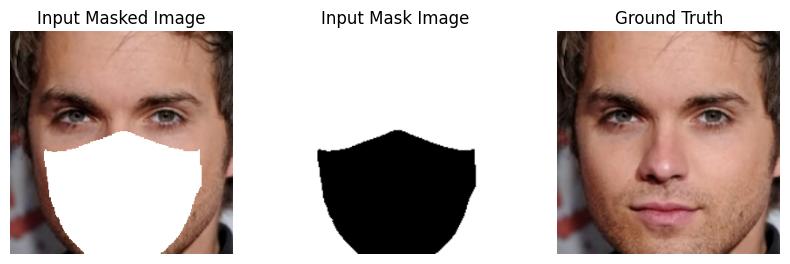

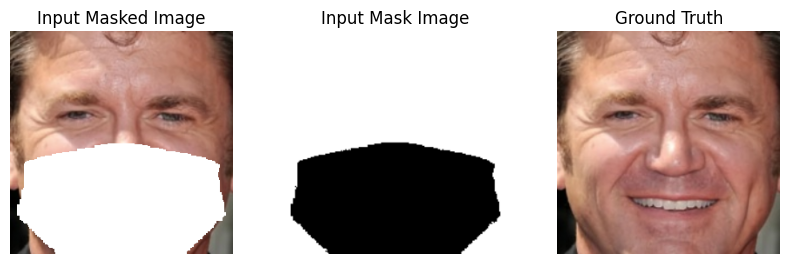

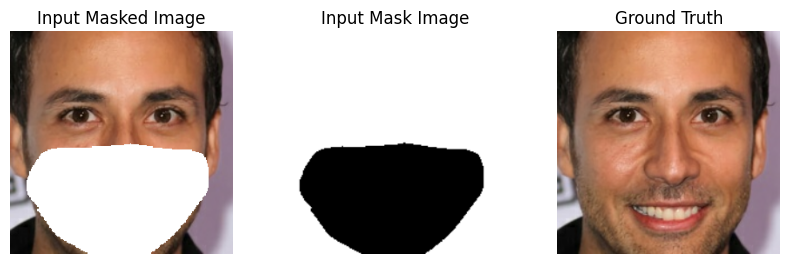

In [ ]:
def display(display_list):
  plt.figure(figsize=(8, 8))
  title = ['Input Masked Image', 'Input Mask Image', 'Ground Truth']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.tight_layout()
    plt.axis('off')
  plt.show()

for target_batch, path_batch in trainds.take(1):
  (masked_batch, mask_batch, box_batch), target_batch = create_myinput_dataset(target_batch, path_batch, batch_size=BATCH_SIZE)

for b in range(BATCH_SIZE):
  display([masked_batch[b], mask_batch[b], target_batch[b]])

## Train The Model

### Initial training

In [ ]:
model = build_pconv_unet(img_shape=IMG_SHAPE)
model.load_weights('/content/drive/MyDrive/GP5_Ghaida undermask_2022/Implementation on Colab/Image Inpainting Module/Models/last try/Deep-vanilla-L&G_D-epoch-4-2023-06-12-06-48-39.h5')


In [ ]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [ ]:
opt_train_01 = tf.keras.optimizers.Adam(learning_rate=0.0002)

history_01 = fit(
                model=model,
                g_discriminator=g_discriminator,
                input_data=iter(trainds),
                validation_data= iter(valds),
                epochs=2,
                batch_size= BATCH_SIZE,
                steps_per_epoch=int(len(trainfiles)/BATCH_SIZE),
                validation_steps = int(len(valfiles)/BATCH_SIZE),
                optimizer = opt_train_01,
                save_dir='/content/drive/MyDrive/GP5_Ghaida undermask_2022/Implementation on Colab/Image Inpainting Module/Models/last try'
            )

# Open a file and use dump()
with open('/content/drive/MyDrive/GP5_Ghaida undermask_2022/Implementation on Colab/Image Inpainting Module/Models/last try/train.pkl', 'wb') as file:

    # A new file will be created
    pickle.dump(history_01,file)


Start of epoch 0
Epoch 1/2, Loss: 0.22201770544052124023, Step:4247 of 4389

In [ ]:
save_dir='/content/drive/MyDrive/GP5_Ghaida undermask_2022/Implementation on Colab/Image Inpainting Module/Models/last try/test'
epoch = 1
datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

checkpoint_name = save_dir + '/Deep-vanilla-L&G_D-epoch-' + 'last' + '-' + datetime.now().strftime('%Y-%m-%d-%H-%M-%S') + '.h5'
model.save_weights(checkpoint_name, overwrite=True, save_format='h5')

# g_discriminator_checkpoint_name = save_dir + '/Deep-g_discriminator-epoch-' + str(epoch) + '-' + datetime.now().strftime('%Y-%m-%d-%H-%M-%S') + '.h5'
# g_discriminator.save_weights(g_discriminator_checkpoint_name, overwrite=True, save_format='h5')

# l_discriminator_checkpoint_name = save_dir + '/l_discriminator-epoch-' + str(epoch) + '-' + datetime.now().strftime('%Y-%m-%d-%H-%M-%S') + '.h5'
# L_discriminator.save_weights(l_discriminator_checkpoint_name, overwrite=True, save_format='h5')

### Fine-tuning

In [ ]:
model = build_pconv_unet(img_shape=IMG_SHAPE, fine_tuning=True)
model.load_weights('/content/drive/MyDrive/GP5_Ghaida undermask_2022/Implementation on Colab/Image Inpainting Module/Models/vanilla-epoch-9-2023-06-12-03-22-56.h5')
opt_train_02 = tf.keras.optimizers.Adam(learning_rate=0.00005)

history_02 = fit(model=model,
                 input_data=iter(trainds),
                 batch_size=BATCH_SIZE,
                 epochs=5,
                 steps_per_epoch=200,
                 validation_data=iter(valds),
                 validation_steps=110,
                 vgg16=vgg16,
                 optimizer=opt_train_02,
                 save_dir='/content/drive/MyDrive/GP5_Ghaida undermask_2022/Implementation on Colab/Image Inpainting Module/Models')

In [ ]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
model.compile(#optimizer='rmsprop', # accuracy: 96.60%
              optimizer='adam', #using adam the accuracy ranged between 97.02-97.72%
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

## Visualize Model Outputs

### Prepare Test Data

#### Detector Class

In [ ]:
class Metadata:
    def get(self, _):
        return ['book','box','candy','cap','cigarette','cup','envelope','fastfood','flower','fruit','glove','hand','keys','mask','mic','pen','phone','scarf','sunglasses']

class Detector:
    def __init__(self):
        self.cfg = get_cfg()
        #loading model config and pretrained model

        self.cfg.merge_from_file(model_zoo.get_config_file(CONFIG_FILE_PATH))
        self.cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/GP5_Ghaida undermask_2022/Implementation on Colab/Image Inpainting Module/Models/Detecron2/model_final.pth"
        self.cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES
        self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
        self.predictor = DefaultPredictor(self.cfg)

    ### Detection on images
    def forImages(self, imPath):

       img = cv2.imread(imPath)
       outputs = self.predictor(img)
       file =  os.path.basename(imPath)

       visualizer = Visualizer(
            img[:, :, ::-1],
            metadata= Metadata,
            scale=0.8,
            instance_mode=ColorMode.IMAGE_BW
        )
       out = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))

       output = np.zeros_like(img) #binary mask (black background)

       # ##“pred_masks”: a Tensor of shape (N, H, W), masks for each detected instance.
       mask_array = outputs['instances'].pred_masks.cpu().numpy()
       num_instances = mask_array.shape[0]
       mask_array = np.moveaxis(mask_array, 0, -1)
       mask_array_instance = []

       for i in range(num_instances):
            mask_array_instance.append(mask_array[:, :, i:(i+1)])
            output = np.where(mask_array_instance[i] == True, 255, output)

       image = Image.fromarray(output)
       smoothed_out = image.filter(ImageFilter.SMOOTH_MORE) #  image.filter(ImageFilter.SMOOTH)
       smoothed_out = smoothed_out.point((lambda p: 255 if p > 1 else 0))
       smoothed_out = image.filter(ImageFilter.SMOOTH_MORE) #  image.filter(ImageFilter.SMOOTH)
       smoothed_out = smoothed_out.point((lambda p: 255 if p > 1 else 0))
       smoothed_out = np.array(smoothed_out)
       #r1 = r1.point((lambda p: 255 if p > 1 else 0))

       os.makedirs('./smoothed_bin_masks/', exist_ok=True)
       cv2.imwrite('./smoothed_bin_masks/'+ file, smoothed_out)#smoothed mask

       os.makedirs('./bin_masks/', exist_ok=True)
       os.makedirs('./orig_masks/', exist_ok=True)
       cv2.imwrite('./bin_masks/'+ file, output)#mask
       cv2.imwrite('./orig_masks/'+ file, out.get_image()[:, :, ::-1])#orig

detector = Detector()

#### Load Testing Data

In [ ]:
def load(path):
    as_string = tf.io.read_file(path)
    as_image = tf.image.decode_png(as_string, channels=3)
    resized = tf.image.resize(as_image, (256, 256))
    normalized = tf.divide(resized, 255)
    return normalized, path

def load_predicted(path):
    filename = os.path.basename(bytes.decode(path.numpy()))
    path = "./orig_masks/" + filename
    as_string = tf.io.read_file(path)
    as_image = tf.image.decode_png(as_string, channels=3)
    resized = tf.image.resize(as_image, (256, 256))
    normalized = tf.divide(resized, 255)
    return normalized

def load_orig(path):
    filename = os.path.basename(bytes.decode(path.numpy()))
    dir = os.path.dirname(bytes.decode(path.numpy()))
    folders = os.path.basename(os.path.dirname(dir)) + '/' + os.path.basename(dir) + '/'
    file = folders + filename
    path = "/content/drive/MyDrive/GP5_Ghaida undermask_2022/Dataset/2 Versions (Custom Datasets)/MFDataset/Orig_imgs/" + file
    as_string = tf.io.read_file(path)
    as_image = tf.image.decode_png(as_string, channels=3)
    resized = tf.image.resize(as_image, (256, 256))
    normalized = tf.divide(resized, 255)
    return normalized

def load_mask(path):
    filename = os.path.basename(bytes.decode(path.numpy()))
    path = "./smoothed_bin_mask/" + filename
    as_string = tf.io.read_file(path)
    as_image = tf.image.decode_png(as_string, channels=3)
    resized = tf.image.resize(as_image, (256, 256))
    normalized = tf.divide(resized, 255)
    return normalized

def create_myinput_dataset(image_batch, path_batch, batch_size):
    orig_batch = np.stack(
        [load_orig(path_batch[_]) for _ in range(len(path_batch))],
        axis=0)
    detected_batch = np.stack(
        [load_predicted(path_batch[_]) for _ in range(len(path_batch))],
        axis=0)
    mask_batch = np.stack(
        [load_mask(path_batch[_]) for _ in range(len(path_batch))],
        axis=0)
    mask_batch = 1- mask_batch
    # Condition tensor
    bool_mask_batch = tf.convert_to_tensor(mask_batch.copy().astype('bool'), dtype=tf.bool)

    mask_batch = tf.convert_to_tensor(mask_batch, dtype=tf.float32)
    masked_batch = tf.where(bool_mask_batch, image_batch, 1.0)

    return (masked_batch, mask_batch), (orig_batch, detected_batch), image_batch

testoccfiles = glob('/content/drive/MyDrive/GP5_Ghaida undermask_2022/Dataset/2 Versions (Custom Datasets)/MFDataset/Occ_imgs/test/**/*.png')
for image in testoccfiles:
    detector.forImages(image)
testds = tf.data.Dataset.from_tensor_slices(testoccfiles).map(load)
testds = testds.batch(BATCH_SIZE).repeat().shuffle(buffer_size=100)
testds = testds.prefetch(buffer_size=AUTOTUNE)

### Visualize Test Results of The Inpainting with Detectron2 Instance Segmentation

In [ ]:
model = build_pconv_unet(img_shape=IMG_SHAPE)
model.load_weights('/content/drive/MyDrive/GP5_Ghaida undermask_2022/Implementation on Colab/Image Inpainting Module/Models/Deep-vanilla-L&G_D-epoch-0-2023-06-13-02-57-49.h5')


In [ ]:
for test_target_batch, test_path_batch in testds.take(2):
  (test_masked_batch, test_mask_batch), (test_target_batch, test_detected_batch), test_image_batch = create_myinput_dataset(test_target_batch, test_path_batch, batch_size=BATCH_SIZE)
test_result = model.predict([test_masked_batch, test_mask_batch])

1/1 [==============================] - 0s 27ms/step


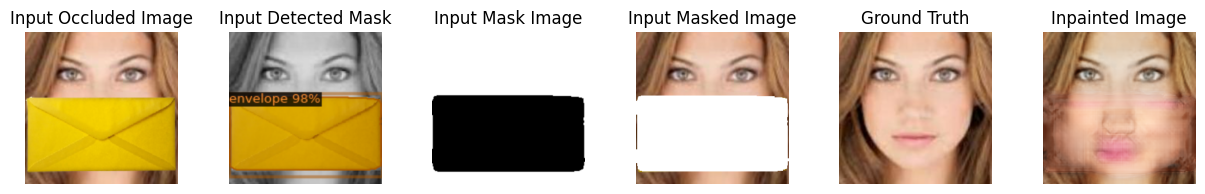

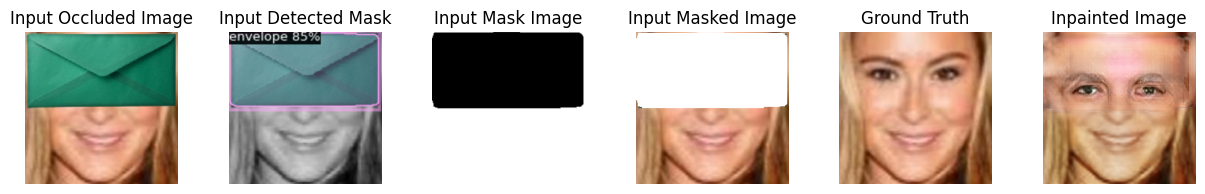

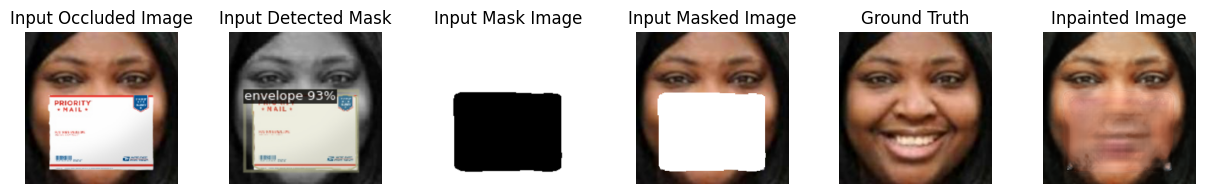

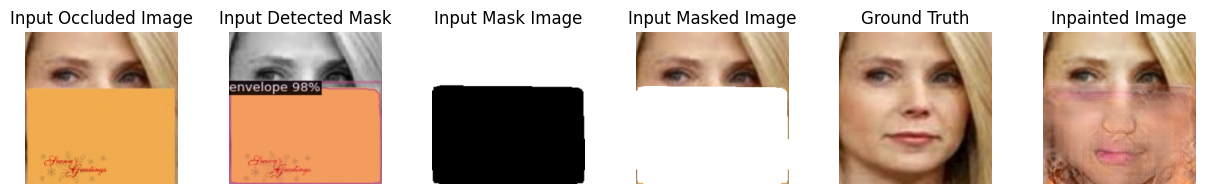

In [ ]:
def display(display_list):
  plt.figure(figsize=(12, 12))
  title = ['Input Occluded Image', 'Input Detected Mask', 'Input Mask Image', 'Input Masked Image', 'Ground Truth', 'Inpainted Image']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.tight_layout()
    plt.axis('off')
  plt.show()

for idx in range(BATCH_SIZE):
  display([test_image_batch[idx], test_detected_batch[idx], test_mask_batch[idx], test_masked_batch[idx], test_target_batch[idx], test_result[idx]])